# Sparse logistic regression

Consider a dataset of $M$ rows and $N$ columns, so that $\mathbf{A} = \text{col}(\mathbf{a}^\top_i)_{i =1}^M \in \mathbb{R}^{M \times N}$ is the dataset matrix, and $\mathbf{a}_i \in \mathbb{R}^{N}$ is the $i$-th features vector for the $i$-th dataset row. Moreover, let $\mathbf{b} \in \mathbb{R}^M$ be the target vector, so that $b_i \in \{-1,1\}$ is the (binary) ground truth for the $i$-th data entry. 
The sparse logistic regression consists of finding the weight vector $\mathbf{x} \in \mathbb{R}^N$ that minimizes the following loss function [1]

$$
\begin{align}
    \label{eq:regression}
        f(\mathbf{x}) := \sum_{i = 1}^M \log\left(1 + \frac{1}{\exp(b_i \mathbf{a}^\top_i \mathbf{x})} \right) + \gamma \|\mathbf{x}\|_1
        \\ \nonumber
        = \underbrace{\mathbf{1}^\top_M \log(1 + \exp(-\mathbf{b} \odot \mathbf{A} \mathbf{x}))}_{=:s(\mathbf{x})} + \underbrace{\gamma \|\mathbf{x}\|_1}_{=:g(\mathbf{x})} 
\end{align}
$$

where $\gamma \in \mathbb{R}_{> 0}$ is the $\ell_1$-regulation strength. The gradient for $s(\cdot)$, $\nabla s_\mathbf{x}(\mathbf{x})$, is calculated as

$$
\begin{equation}
    F(\mathbf{x}) = \nabla s_\mathbf{x}(\mathbf{x}) = -\frac{\mathbf{A}^\top \odot (\mathbf{1}_N \otimes \mathbf{b}^\top) \odot \exp(-\mathbf{b} \odot \mathbf{A} \mathbf{x})}{1 + \exp(-\mathbf{b} \odot \mathbf{A} \mathbf{x})} \mathbf{1}_M
\end{equation}
$$

The problem of finding the minimizer for $\eqref{eq:regression}$ can be cast as a canonical VI, with $F(\mathbf{x}) := \nabla s_\mathbf{x}(\mathbf{x})$. Let's start by defining the train matrix, target vector, and regularization strength.

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from monviso import VI

np.random.seed(2024)

N, M = 500, 200

A = np.random.normal(size=(M, N))
b = np.random.choice([-1, 1], size=M)
gamma = 0.005 * np.linalg.norm(A.T @ b, np.inf)

From the definition, the $\mathbf{F}(\cdot)$ and $g(\cdot)$ are defined as

In [2]:
F = lambda x: -np.sum(
    (A.T * np.tile(b, (N, 1))) * np.exp(-b * (A @ x)) / (1 + np.exp(-b * (A @ x))),
    axis=1,
)
g = lambda x: gamma * cp.norm(x, 1)
L = 1.5

Let's instantiate the VI and create an initial point

In [3]:
slr = VI(F, g=g)
x = np.random.rand(N)

As examples, let's use the Hybrid Golden Ratio Algorithm I (), the Golden ratio algorithm (), and the adaptive golden ratio algorithm ()

In [30]:
GOLDEN_RATIO = 0.5*(1 + np.sqrt(5))
max_iter = 200

residuals_hgraal = np.zeros(max_iter)
residuals_graal = np.zeros(max_iter)
residuals_agraal = np.zeros(max_iter)

xk_hgraal, x1k_hgraal, yk_hgraal, s1k_hgraal, tk_hgraal, ck_hgraal = \
    np.copy(x), np.random.rand(N), np.copy(x), GOLDEN_RATIO/(2*L), 1, 1
xk_graal, yk_graal = np.copy(x), np.copy(x)
xk_agraal, x1k_agraal, yk_agraal, s1k_agraal, tk_agraal = \
    np.copy(x), np.random.rand(N), np.copy(x), GOLDEN_RATIO/(2*L), 1

for k in range(max_iter):
    # Hybrid Golden Ratio Algorithm I
    xk1_hgraal, yk1_hgraal, sk_hgraal, tk1_hgraal, ck1_hgraal = \
        slr.hgraal_1(xk_hgraal, x1k_hgraal, yk_hgraal, s1k_hgraal, tk_hgraal, ck_hgraal)
    
    residuals_hgraal[k] = np.linalg.norm(xk1_hgraal - xk_hgraal)
    
    xk_hgraal, x1k_hgraal, yk_hgraal, s1k_hgraal, tk_hgraal, ck_hgraal = \
        xk1_hgraal, xk_hgraal, yk1_hgraal, sk_hgraal, tk1_hgraal, ck1_hgraal

    # Golden ratio algorithm
    xk1_graal, yk1_graal = slr.graal(xk_graal, yk_graal, step_size=GOLDEN_RATIO/(2*L))
    residuals_graal[k] = np.linalg.norm(xk1_graal - xk_graal)
    xk_graal, yk_graal = xk1_graal, yk1_graal
    
    # Adaptive golden ratio algorithm
    xk1_agraal, yk1_agraal, sk_agraal, tk1_agraal = slr.agraal(xk_agraal, x1k_agraal, yk_agraal, s1k_agraal, tk_agraal)
    residuals_agraal[k] = np.linalg.norm(xk1_agraal - xk_agraal)
    xk_agraal, x1k_agraal, yk_agraal, s1k_agraal, tk_agraal = xk1_agraal, xk_agraal, yk1_agraal, sk_agraal, tk1_agraal

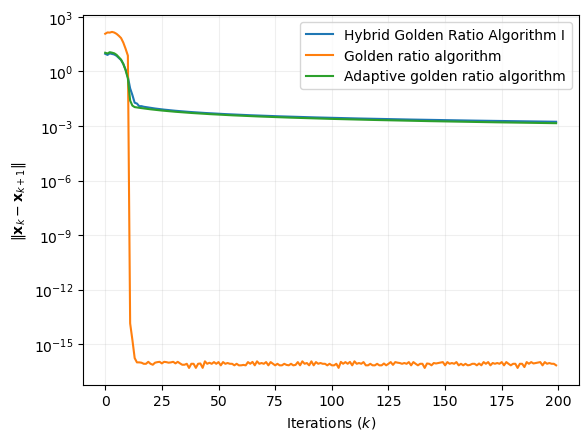

In [35]:
fig, ax = plt.subplots()
ax.plot(residuals_hgraal, label="Hybrid Golden Ratio Algorithm I")
ax.plot(residuals_graal, label="Golden ratio algorithm")
ax.plot(residuals_agraal, label="Adaptive golden ratio algorithm")
plt.yscale('log')

ax.grid(True, alpha=0.2)
ax.set_xlabel("Iterations ($k$)")
ax.set_ylabel(r"$\|\mathbf{x}_k - \mathbf{x}_{k+1}\|$")
plt.legend()
plt.show()

## References
[1] Mishchenko, K. (2023). Regularized Newton method with global convergence. SIAM Journal on Optimization, 33(3), 1440-1462.